In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from config import *

# prepare data

In [ ]:
# fetch data
index_code = '000905.XSHG'
index_short_code = 'zz500'
index_data_path = CSI500_PATH

# index pirce
index_price = pd.read_csv(os.path.join(DATA_PATH,'index_price_1d.csv'))
index_price = index_price[index_price['order_book_id'] == index_code]
index_price['date'] = pd.to_datetime(index_price['date'])

# index component weigths
index_weight = pd.read_csv(os.path.join(index_data_path, f'{index_short_code}_weight.csv'), index_col=0)
index_weight.columns = ['order_book_id', 'weight', 'date']
index_weight['date'] = pd.to_datetime(index_weight['date'], format='%Y%m%d')

# index component price
stock_price = pd.read_csv(os.path.join(index_data_path, f'{index_short_code}_1d.csv'), index_col=0)
stock_price['date'] = pd.to_datetime(stock_price['date'])

# get sector stock map  
sector_map = pickle.load(open(os.path.join(DATA_PATH,'sec_map.pkl'), 'rb'))
stk_sec_map = {}
for sec, stk_list in sector_map.items():
    for stk in stk_list:
        stk_sec_map[stk] = sec

# merge data
stock_merged = stock_price.merge(index_weight, on=['order_book_id', 'date'], how='inner')
stock_merged['GICS'] = stock_merged['order_book_id'].apply(lambda x: stk_sec_map.get(x, None))
stock_merged = stock_merged.sort_values(by=['date', 'weight'], ascending=[True, False])
stock_merged['return'] = stock_merged.groupby('order_book_id')['close'].pct_change()


# calculate vol and plot check

In [ ]:
# calculate intrady volatility (high/low)
stock_merged['intraday_vol'] = np.log(stock_merged['high'] / stock_merged['low']) # individual stock intraday volatility

# calculate components volatility by weighted average of stock volatility, and average of stock volatility
stock_vol_mean = stock_merged.groupby('date')['intraday_vol'].mean().reset_index()
stock_vol_weighted = stock_merged.groupby('date').apply(lambda x: np.average(x['intraday_vol'], weights=x['weight'])).reset_index().rename(columns={0:'intraday_vol'})

# calculate index volatility by index price
index_price['index_vol'] = np.log(index_price['high'] / index_price['low'])

<Axes: xlabel='date'>

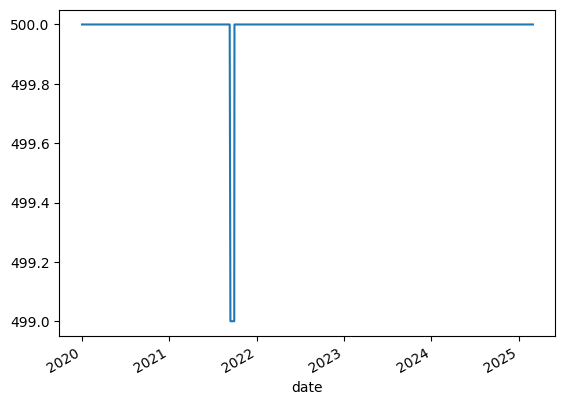

In [10]:
# check index components amount
stock_merged[stock_merged['weight']>0].groupby('date')['order_book_id'].count().plot()

In [18]:

# plot intraday vol in the same plot
fig = make_subplots()
fig.add_trace(go.Scatter(x=index_price['date'], y=index_price['index_vol'], mode='lines', name='index intraday vol'))
fig.add_trace(go.Scatter(x=stock_vol_mean['date'], y=stock_vol_mean['intraday_vol'], mode='lines', name='mean components intraday vol'))
fig.add_trace(go.Scatter(x=stock_vol_weighted['date'], y=stock_vol_weighted['intraday_vol'], mode='lines', name='weighted components intraday vol'))
fig.update_layout(title_text='Index Vol vs Components Intraday Vol')


# # plot smoothed vol

# index_price['smoothed_index_vol'] = index_price['index_vol'].rolling(window=20).mean()
# vol_df['smoothed_intraday_vol'] = vol_df['intraday_vol'].rolling(window=20).mean()

# fig = make_subplots()
# fig.add_trace(go.Scatter(x=index_price['date'], y=index_price['smoothed_index_vol'], mode='lines', name='smoothed index vol'))
# fig.add_trace(go.Scatter(x=vol_df['date'], y=vol_df['smoothed_intraday_vol'], mode='lines', name='smoothed mean intraday vol'))

# fig.update_layout(title_text='Smoothed Index Vol vs Smoothed mean Intraday Vol')

In [ ]:
# index_price['index_vol'] = np.log(index_price['high'] / index_price['low'])
# merged['industry_weight'] = merged['weight'] / merged.groupby(['date', 'GICS'])['weight'].transform('sum')
# vol_df = merged.groupby(['date','GICS']).apply(lambda x: np.sum(x['intraday_vol'] * x['industry_weight'])).reset_index().rename(columns={0: 'industry_weighted_intraday_vol'})

# # plot industry vol and index vol in the same plot

# fig = make_subplots()

# fig.add_trace(go.Scatter(x=index_price['date'], y=index_price['index_vol'], mode='lines', name='index vol'))

# for sec in vol_df['GICS'].unique():
#     tmp = vol_df[vol_df['GICS'] == sec]
#     fig.add_trace(go.Scatter(x=tmp['date'], y=tmp['industry_weighted_intraday_vol'], mode='lines', name=sec))

# fig.update_layout(title_text='Index Vol vs Industry Weighted Intraday Vol')
# fig.show()

# # plot smoothed industry vol
# vol_df['smoothed_industry_weighted_intraday_vol'] = vol_df.groupby('GICS')['industry_weighted_intraday_vol'].transform(lambda x: x.rolling(window=20).mean())

# fig = make_subplots()

# # smooth index vol
# index_price['smoothed_index_vol'] = index_price['index_vol'].rolling(window=20).mean()
# fig.add_trace(go.Scatter(x=index_price['date'], y=index_price['smoothed_index_vol'], mode='lines', name='index vol'))

# for sec in vol_df['GICS'].unique():
#     tmp = vol_df[vol_df['GICS'] == sec]
#     fig.add_trace(go.Scatter(x=tmp['date'], y=tmp['smoothed_industry_weighted_intraday_vol'], mode='lines', name=sec))

# fig.update_layout(title_text='Index Vol vs Smoothed Industry Weighted Intraday Vol')
# fig.show()

/var/folders/1f/5ggn6k991fv0z5vzr6xpyxx80000gn/T/ipykernel_52399/2990473487.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
# pair wise trading, trading volatility